# Numerical Optimization — Gradient Descent Method

## Introduction

Gradient descent is a first-order iterative optimization algorithm for finding a local minimum of a differentiable function. It uses the first-order information about the optimized function, i.e. its gradient, to determine the direction of the steepest descent. This algorithm is commonly used in machine and deep learning to minimize a cost function of a model being trained.

Below is an illustration of how the gradient descent algorithm finds a minimum of a function of two variables. The function is depicted by its level curve plot, such that the inner curves correspond to smaller values of the function. The algorithm starts with the point $x_0$, determines the steepest descent direction, and moves to a new point $x_1$ along this direction depending on the step length. These steps are repeated until the stopping condition is met.

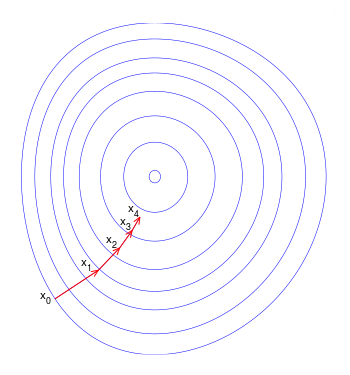

*The path taken by the gradient descent algorithm. [Source](https://en.wikipedia.org/wiki/Gradient_descent)*

Given a differentiable function $f(x)$, the procedure for updating the current point $x_{curr}$ is enclosed in the two following formulae:

$$\Delta x_{curr}=-\alpha\nabla f(x_{prev}),\tag{1}$$

$$x_{curr}=x_{prev}+\Delta x_{curr},\tag{2}$$

where $\Delta x_{curr}$ is a current change also called delta, $\alpha$ is a step length, and $x_{prev}$ is a previous point. As you can see, in the gradient descent method the direction is chosen to be a negative gradient as it represents the direction of the steepest descent.

The step length has a very high impact on the convergence properties of a given optimization problem. The picture below illustrates the idea by providing two extreme examples. A very small step results in slow convergence, while a very large one makes the optimization fail to converge.

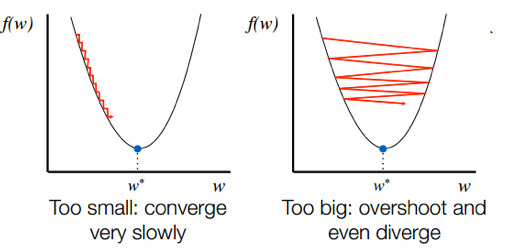

*Impact of a small and a large step. [Source](https://laptrinhx.com/artificial-neural-networks-part-3-loss-and-cost-functions-and-gradient-descent-507013705/)*

Generally, the step length is determined using a line search. However, there are other techniques in machine/deep learning applications such as learning rate schedule and adaptive learning rate. Throughout these exercises, we will be using constant step length.

Apart from the convergence problems caused by inadequately chosen step length, the gradient descent method may face another problem — the gradient can oscillate around a stable trajectory causing slow convergence. The gradient descent with momentum mitigates this problem by tending to keep traveling in the same direction. The picture below shows how this modification reduces the oscillations.

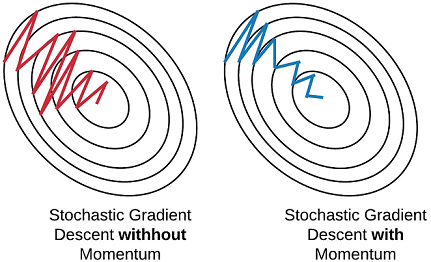

*Gradient descent and its momentum modification. [Source](https://eloquentarduino.github.io/2020/04/stochastic-gradient-descent-on-your-microcontroller/)*

Instead of using the direction of the steepest descent at each iteration, the gradient descent with momentum combines it with the direction used in the previous iteration. Therefore, only the formula for $\Delta x_{curr}$ needs to be changed.

$$\Delta x_{curr}=\beta \Delta x_{prev}-\alpha\nabla f(x_{prev}),\tag{3}$$

where $\beta$ is a decay factor determining how much the previous direction influences the current one.

As termination criteria we are going to use the norm of the previous delta in conjunction with the iteration counter:

$$\lVert\Delta x_{prev}\rVert\leq\epsilon,\tag{4}$$

$$iter>maxIter,\tag{5}$$

where $\epsilon$ is a sufficiently small tolerance value, $iter$ is an iteration counter, and $maxIter$ is the maximum number of iterations. The algorithm should stop if at least one of these conditions is satisfied.

The algorithm behind gradient descent and gradient descent with momentum consists of the following steps:

1.   Initialize $x_{prev}$ with the guess value, and set $iter$ to zero. Initialize $\alpha$, $\epsilon$ and $maxIter$ with desired values. If the momentum is used initialize $\Delta x_{prev}$ with a zero vector and $\beta$ with an appropriate value;
2.   Compute the current delta $\Delta x_{curr}$ using either (1) or (3) depending on the chosen method;
3.   Compute the current point $x_{curr}$ using (2). Assign $\Delta x_{prev}$ a value of $\Delta x_{curr}$ if the momentum is used;
4.   Increment the iteration counter $iter$;
5.   Check the termination criteria (4) and (5). If at least one of them is satisfied then stop the algorithm. Otherwise, go to step 2.

We will implement optimizers for gradient descent and gradient descent with momentum in the following sections. After that, the optimizers will be tested on various functions.

## Gradient Descent and Gradient Descent with Momentum

We would like to implement a class to encapsulate functionality common for both gradient descent and gradient descent with momentum, namely:

*   Providing the ability for subclasses to define their own way of computing the current delta $\Delta x_{curr}$;
*   Maintaining optimization history — a path taken by the optimization algorithm consisting of points $x_{curr}$ taken from each iteration;
*   Maintaining the iteration counter and checking the termination criteria;
*   Working with various types of optimization parameters.

The last point is included since there are optimization problems where we may deal with not just a single vector but with lists of vectors or matrices with different dimensions — something that one usually encounters in neural networks.



#### Optimizer class

The class **Optimizer** containing the above-listed functionalities is implemented below. Let us run through the methods of this class first:


*   The method **update(values, grads, key)** computes the updated values of the
parameter identified by **key**. The method is supplied with the list of the current values **values** and the list of the corresponding gradients **grads** of the parameter. Obviously, these lists should have the same number of elements. If **values** and **grads** are not lists the method will wrap them into lists. This is done to make the **Optimizer** class more friendly toward optimization problems where there is only one vector/matrix per parameter. The method then computes the deltas for the parameter using the protected method **_deltas(grads, key)** which is to be overridden by the subclasses, and applies them to the current values **values**. After that, the method saves the updated values to the list located in the dictionary **history** under the key **key**. Finally, the method returns the list of the updated values or its first entry, depending on how the data were supplied to the method in the first place.
*   The method **run(key)** increments the iteration counter and checks the termination criteria — the maximum number of iterations and the norm of the previous delta for the parameter identified by **key**. This method is used only for optimization problems with a single parameter in a form of a single vector (not a list). It uses the dictionary **last_deltas** to access the previous delta for the parameter. Normally, the dictionary will yield a list, but the norm is computed only for the first entry of such a list.
*   The method **get_iter()** simply returns the current value of the iteration counter.
*   The method **get_history(key)** returns the optimization history for the parameter identified by **key**. If there is only one vector/matrix per parameter instead of returning a list the method returns a single element.


In such methods as **update(values, grads, key)**, **run(key)**, **get_history(key)** by default **key** is set to **'default'** to make things easier for the optimization problems with only one parameter. In other words, the optimization problem with a single vector of parameters will result in dictionaries **history** and **last_deltas** having only one key **'default'** associated with a list of only one entry.

By the way, this is the case where it makes sense to use the method **run(key)**. In more sophisticated applications there might be more parameters represented by several vectors or matrices, and the need for such a method vanishes as it makes no sense in such a setup.

Let us take a closer look at the attributes **last_deltas** and **history**. Suppose we have two types of parameters that is weights and biases. We denote them by keys **'W'** and **'b'** respectively. Now assume that there are 3 matrices of weights and 3 vectors of biases (e.g. 3 layers of a neural network). The above-mentioned attributes will look like? The answer is:

*last_deltas = {*

  *'W': [W1, W2, W3],*
  
  *'b': [b1, b2, b3]*

*}*

*history = {*

  *'W': [[W1, W2, W3], [W1, W2, W3], ..., [W1, W2, W3]],*
  
  *'b': [[b1, b2, b3], [b1, b2, b3], ..., [b1, b2, b3]]*

*}*

That is **last_deltas** is a dictionary of lists of vectors/matrices, and **history** is a dictionary of lists containing lists of vectors/matrices for each iteration of the algorithm.

In [1]:
import numpy as np
import numpy.linalg as la

class Optimizer:
  """
  Optimizer
  """

  def __init__(self, alpha, max_iter, eps, record):
    """
    Creates an instance of the optimizer
    Arguments:
        alpha: a step size
        max_iter: a maximum number of iterations
        eps: a tolerance value
        record: a flag for recording optimization history
    Returns:
        Optimizer
    """
    self.alpha = alpha
    self.max_iter = max_iter
    self.eps = eps
    self.record = record
    self.iter = None
    self.last_deltas = {}
    self.history = {}

  def _deltas(self, grads, key):
    """
    Computes the deltas based on the gradients
    Arguments:
        values: a list containing the current values of the parameter
        grads: a list containing the current gradients of the parameter
        key: a key identifying the type of the parameter
    Returns:
        The list containing the updated values of the parameter
    """
    pass

  def update(self, values, grads, key='default'):
    """
    Updates the parameters
    Arguments:
        values: a list containing the current values of the parameter
        grads: a list containing the current gradients of the parameter
        key: a key identifying the type of the parameter
    Returns:
        The list containing the updated values of the parameter
    """
    # Wrap the values and deltas if necessary
    if type(values) is not list:
      values = [values]
    if type(grads) is not list:
      grads = [grads]

    # Compute the deltas
    deltas = self._deltas(grads, key)

    # Compute the updated values
    updated_values = [entry[0] + entry[1] for entry in zip(values, deltas)]

    # Store the updated values if necessary
    if self.record:
      if key not in self.history:
        self.history[key] = [values]
      self.history[key].append(updated_values)

    # Unwrap the updated values if necessary
    if len(updated_values) < 2:
      updated_values = updated_values[0]

    # Return the updated values
    return updated_values

  def run(self, key='default'):
    """
    Updates the iteration counter and checks the termination criteria
    Returns:
        False if the optimization should be terminated, and True otherwise
    """
    # Initialize the iteration counter
    if self.iter is None:
      self.iter = 0
      return True

    # Increment the iteration counter
    self.iter = self.iter + 1

    # Check the iteration counter
    if self.iter > self.max_iter - 1:
      return False

    # Compute the delta norm
    delta_norm = la.norm(self.last_deltas[key][0])

    # Check the delta norm
    if delta_norm < self.eps:
      return False

    return True

  def get_iter(self):
    """
    Returns the iteration counter
    Returns:
        The iteration counter
    """
    return self.iter

  def get_history(self, key='default'):
    """
    Returns the optimization history
    Arguments:
        key: a key identifying the type of the parameter
    Returns:
        The optimization history for the parameter with a specified key
    """
    # Retrieve the history
    history = [np.array([h[i] for h in self.history[key]]) for i in range(0, len(self.history[key][0]))]

    # Unwrap the history if necessary
    if len(history) < 2:
      history = history[0]

    # Return the history
    return history

#### GDOptimizer - Gradient Descent Optimizer

Implement the gradient descent optimization class **GDoptimizer**. The method **_deltas(grads, key)** uses the formula (1) to compute the deltas.

In [2]:
class GDoptimizer(Optimizer):
  """
  Gradient descent optimizer
  """

  def __init__(self, alpha, max_iter, eps, record=False):
    """
    Creates an instance of the gradient descent optimizer
    Arguments:
        alpha: a step size
        max_iter: a maximum number of iterations
        eps: a tolerance value
        record: a flag for recording optimization history
    Returns:
        Gradient descent optimizer
    """
    super().__init__(alpha, max_iter, eps, record)

  def _deltas(self, grads, key):
    """
    Computes the deltas based on the gradients
    Arguments:
        grads: a list containing the current gradients of the parameter
        key: a key identifying the type of the parameter
    Returns:
        The list containing the deltas of the parameter
    """
    # Compute the deltas for gradient descent
    deltas = [-self.alpha * grad for grad in grads]

    # Store the deltas
    self.last_deltas[key] = deltas

    # Return the deltas
    return deltas

#### MGDOptimizer - Gradient Descent Optimizer with Momentum

Implement the gradient descent with momentum optimization class **MGDoptimizer** with the method **_deltas(grads, key)**.

In [3]:
class MGDoptimizer(Optimizer):
  """
  Gradient descent optimizer with moment
  """

  def __init__(self, alpha, beta, max_iter, eps, record=False):
    """
    Creates an instance of the gradient descent optimizer with momentum
    Arguments:
        alpha: a step size
        beta: a decay factor
        max_iter: a maximum number of iterations
        eps: a tolerance value
        record: a flag for recording optimization history
    Returns:
        Gradient descent optimizer with momentum
    """
    self.beta = beta
    super().__init__(alpha, max_iter, eps, record)

  def _deltas(self, grads, key):
    """
    Computes the deltas based on the gradients
    Arguments:
        grads: a list containing the current gradients of the parameter
        key: a key identifying the type of the parameter
    Returns:
        The list containing the deltas of the parameter
    """
    # Initialize the last deltas
    if key not in self.last_deltas:
      self.last_deltas[key] = [np.zeros(grad.shape) for grad in grads]

    # Compute the deltas for gradient descent with momentum
    deltas = [self.beta * entry[0] - self.alpha * entry[1] for entry in zip(self.last_deltas[key], grads)]

    # Store the updated deltas
    self.last_deltas[key] = deltas

    # Return the computed deltas
    return deltas

## Testing the optimizers

Now we can test the created optimizers on several functions to be minimized. First, let us create a function providing the optimization loop.

In [4]:
def optimize(x0, func_grad, optimizer):
  """
  Optimizes a function using the specified optimizer
  Arguments:
      x0: an initial point
      func_grad: a gradient of the function
      optimizer: an optimizer
  Returns:
      The local minimum of a function
  """
  # Initialize the current point
  x = x0

  # Run the optimizer until the termination criteria is satisfied
  while optimizer.run():
    # Update the current point
    x = optimizer.update(x, func_grad(x))

  # Return the current point
  return x

Next, we create a function to test and plot the optimization history of both optimizers **GDoptimizer** and **MGDoptimizer** given a certain function, its gradient, step size, decay factor, etc.

In [5]:
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

def test(alpha, beta, x0, xopt, box, func, func_grad, max_iter=5000, eps=1e-4, res=100, uselog=True):
  """
  Tests GDoptimizer and MGDoptimizer on a fiven function
  Arguments:
      alpha: a step size
      beta: a decay factor
      x0: an initial point
      xopt: an minimum point (for reference)
      box: plot boundaries
      func: a function to be minimized
      func_grad: a function's gradient
      max_iter: a maximum number of iterations
      eps: a tolerance value
      res: a plot resolution
      uselog: a flag for taking a logarithm when visualizing the plot
  Returns:
      The local minimum of a function
  """
  # Create the optimizers
  gd = GDoptimizer(alpha, max_iter, eps, True)
  mgd = MGDoptimizer(alpha, beta, max_iter, eps, True)

  # Run the optimizers
  xopt_gd = optimize(x0, func_grad, gd)
  xopt_mgd = optimize(x0, func_grad, mgd)

  # Print the number of iterations
  print('Iterations by GD: ', gd.get_iter())
  print('Iterations by MGD: ', mgd.get_iter())

  # Retrieve the optimization history
  gd_history = gd.get_history()
  mgd_history = mgd.get_history()

  # Create the mesh grid
  x = np.linspace(box[0][0], box[1][0], res)
  y = np.linspace(box[0][1], box[1][1], res)
  xx, yy = np.meshgrid(x, y)

  # Evaluate the function
  z = func(np.array([xx, yy]))

  # Apply log10
  if uselog:
    z = np.log10(z)

  # Set figure size
  plt.figure(figsize=(8, 8), )

  # Plot the function
  cp = plt.contourf(x, y, z, cmap=cm.Blues)
  plt.colorbar(cp)

  # Plot the optimization history
  plt.plot(gd_history[:,0], gd_history[:,1], 'y-')
  plt.plot(mgd_history[:,0], mgd_history[:,1], 'm-')

  # Plot the optimum and guess points
  plt.plot(x0[0], x0[1], 'ro', markersize=8)
  plt.plot(xopt[0], xopt[1], 'g*', markersize=14)

  # Insert legend and set the scaling mode
  plt.legend(['GD', 'MGD', 'Guess', 'Optimum'])
  plt.axis('scaled')

  # Show the plot
  plt.show()

#### Test 1


Given a function

$$f_1(x)=\sin(x_1+x_2)+(x_1-x_2)^2-1.5x_1+2.5x_2+1$$

we will derive its gradient and the code it in the cell below. Then we will visualize the results. Gradient descent with momentum should take fewer iterations to converge and demonstrate fewer oscillations.

Iterations by GD:  49
Iterations by MGD:  17


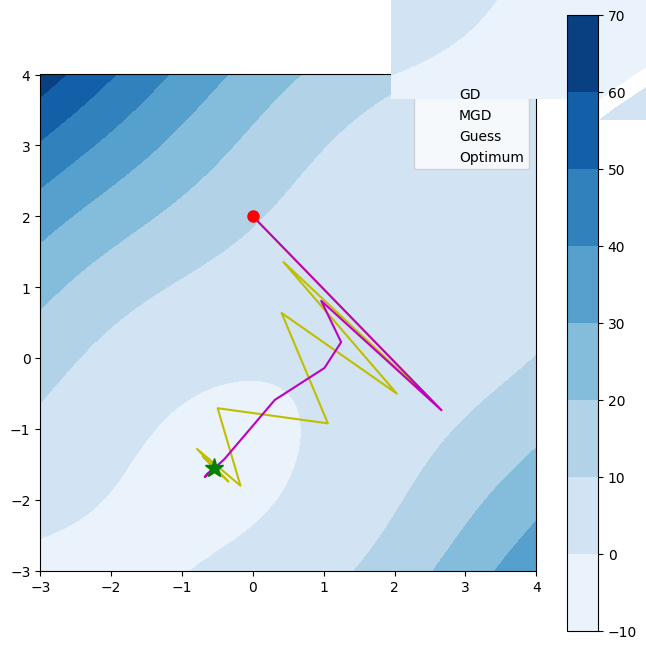

In [8]:
def f1(x):
  return np.sin(x[0] + x[1]) + (x[0] - x[1]) ** 2 - 1.5 * x[0] + 2.5 * x[1] + 1

def df1fx(x):
  return np.array([np.cos(x[0] + x[1]) + 2 * (x[0] - x[1]) - 1.5,
                   np.cos(x[0] + x[1]) - 2 * (x[0] - x[1]) + 2.5])

# Test the optimizers
test(
    # Step length (alpha) and momentum (beta)
    0.450, 0.200,
    # Guess point
    np.array([  0.00000,  2.00000]),
    # Optimum point
    np.array([ -0.54719, -1.54719]),
    # Box
    np.array([[-3.00000, -3.00000],
              [ 4.00000,  4.00000]]),
    # Function and its gradient
    f1, df1fx,
    # Use log
    uselog=False
)

#### Test 2

Given a function

$$f_2(x)=100(x_2-x_1^2)^2+(1-x_1)^2$$

we will derive its gradient and the code it in the cell below. Then we will visualize the results. Gradient descent with momentum should take much fewer iterations to converge than ordinary gradient descent.

Iterations by GD:  4619
Iterations by MGD:  285


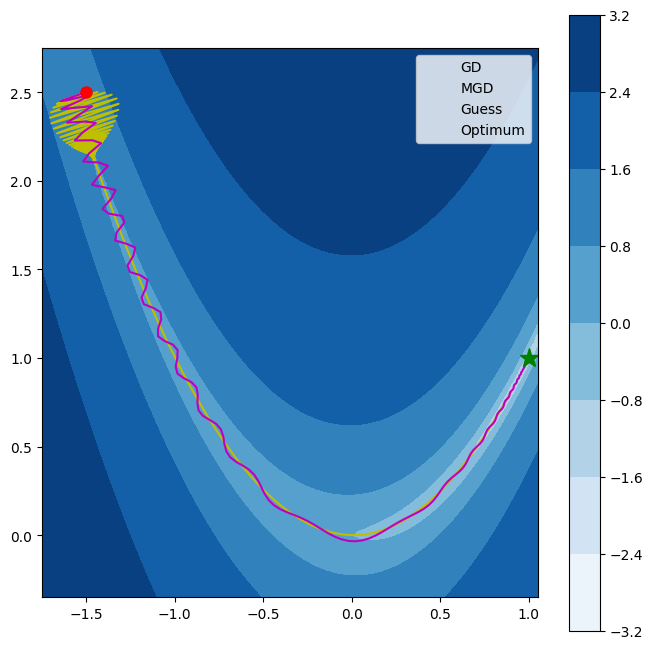

In [9]:
def f2(x):
  return 100 * (x[1] - x[0] ** 2) ** 2 + (1 - x[0]) ** 2

def df2dx(x):
  return np.array([-400 * (x[1] - x[0] ** 2) * x[0] - 2 * (1 - x[0]),
                   200 * (x[1] - x[0] ** 2)])

# Test the optimizers
test(
    # Step length (alpha) and momentum (beta)
    0.001, 0.950,
    # Guess point
    np.array([ -1.50,  2.50]),
    # Optimum point
    np.array([  1.00,  1.00]),
    # Box
    np.array([[-1.75, -0.35],
              [ 1.05,  2.75]]),
    # Function and its gradient
    f2, df2dx
)

#### Test 3

Given a function

$$f_3(x)=(1.5-x_1+x_1x_2)^2+(2.25-x_1+x_1x_2^2)^2+(2.625-x_1+x_1x_2^3)^2$$

we will derive its gradient and the code it in the cell below. Then we will visualize the results. Gradient descent with momentum should take much fewer iterations to converge than ordinary gradient descent, although its path will not be as short.

Iterations by GD:  2729
Iterations by MGD:  741


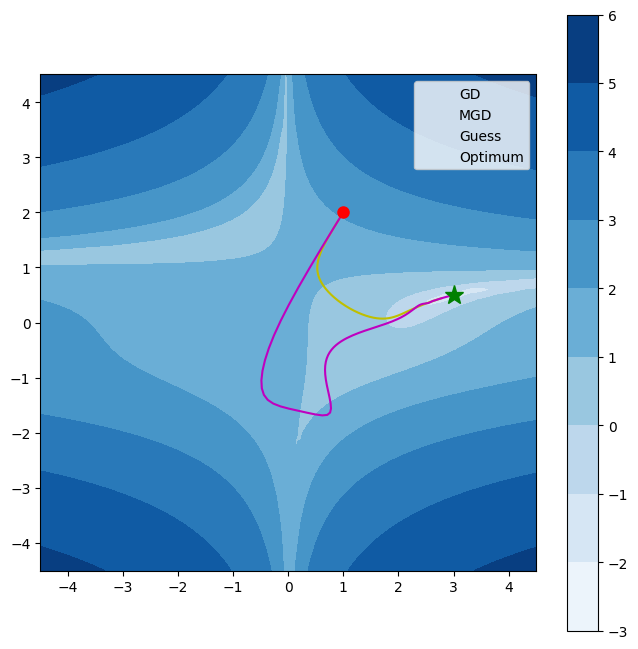

In [10]:
def f3(x):
  return (1.5 - x[0] + x[0] * x[1]) ** 2 + (2.25 - x[0] + x[0] * (x[1] ** 2)) ** 2 + (2.625 - x[0] + x[0] * (x[1] ** 3)) ** 2

def df3dx(x):
  return np.array([2 * (1.5 - x[0] + x[0] * x[1]) * (-1 + x[1]) + 2 * (2.25 - x[0] + x[0] * (x[1] ** 2)) * (-1 + x[1] ** 2) + 2 * (2.625 - x[0] + x[0] * (x[1] ** 3)) * (-1 + x[1] ** 3),
                   2 * (1.5 - x[0] + x[0] * x[1]) * x[0] + 2 * (2.25 - x[0] + x[0] * (x[1] ** 2)) * (2 * x[0] * x[1]) + 2 * (2.625 - x[0] + x[0] * (x[1] ** 3)) * (3 * x[0] * x[1] ** 2)])

# Test the optimizers
test(
    # Step length (alpha) and momentum (beta)
    0.001, 0.910,
    # Guess point
    np.array([  1.0,  2.0]),
    # Optimum point
    np.array([  3.0,  0.5]),
    # Box
    np.array([[-4.5, -4.5],
              [ 4.5,  4.5]]),
    # Function and its gradient
    f3, df3dx
)